<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_cic_2017_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from itertools import combinations, product
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3 , df4,df5,df6,df7,df8], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
np.random.seed(42)
# Sample a small subset of data for testing
df_data = df.sample(frac=0.1, random_state=42)
test_df_http  =  df.sample(frac=0.1, random_state=42)
print(df_data.shape)
# Assuming obj is the object whose datatype you want to check
obj_type = type(df_data)
print(obj_type)


(283074, 79)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# 1.2.1 - Data preprocessing

# Find and handle null values
null_counts = df_data.isnull().sum()
# Print the number of null values
print(f"{null_counts.sum()} null entries have been found in the dataset\n")
# Drop null values
df_data.dropna(inplace=True)          # or df_data = df_data.dropna()

# Find and handle duplicates
duplicate_count = df_data.duplicated().sum()
# Print the numer of duplicate entries
print(f"{duplicate_count} duplicate entries have been found in the dataset\n")
# Remove duplicates
df_data.drop_duplicates(inplace=True)  # or df_data = df_data.drop_duplicates()
# Display relative message
print(f"All duplicates have been removed\n")

# Reset the indexes
df_data.reset_index(drop=True, inplace=True)

# Inspect the dataset for categorical columns
print("Categorical column:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

# Print the first 5 lines
df_data.head()

146 null entries have been found in the dataset

13741 duplicate entries have been found in the dataset

All duplicates have been removed

Categorical column: [' Label'] 



,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,50545,232,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,31226,2,2,68,380,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.0,0.0,999,999,99900000.0,0.0,99900000,99900000,DoS Hulk
3,53,30894,4,2,140,172,35,35,35.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,53,48943,2,2,88,166,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# 1.2.2 - Inspection of Target Feature
# Drop rows containing infinite or NaN values
df_data= df_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
df_data = df_data.dropna()
print('Shape of Dataframe: ',df_data.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_data[' Label'].value_counts())

Shape of Dataframe:  (269037, 79) 

Inspection of Target Feature - y:

 Label
BENIGN                        220396
DoS Hulk                       17663
PortScan                       14551
DDoS                           12851
DoS GoldenEye                   1024
FTP-Patator                      695
DoS slowloris                    572
DoS Slowhttptest                 511
SSH-Patator                      377
Bot                              194
Web Attack � Brute Force         140
Web Attack � XSS                  56
Infiltration                       3
Heartbleed                         2
Web Attack � Sql Injection         2
Name: count, dtype: int64


In [ ]:
# 1.2.3 - Set up binary configuration

# Extract features as X
X = df_data.copy()
X = X.drop(' Label', axis=1)

# Extract target as y
y = df_data[' Label'].copy()

# Binarize labels
y = y.map({'BENIGN': 0}).fillna(1)

<ipython-input-72-79026fcf8b61>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set1')


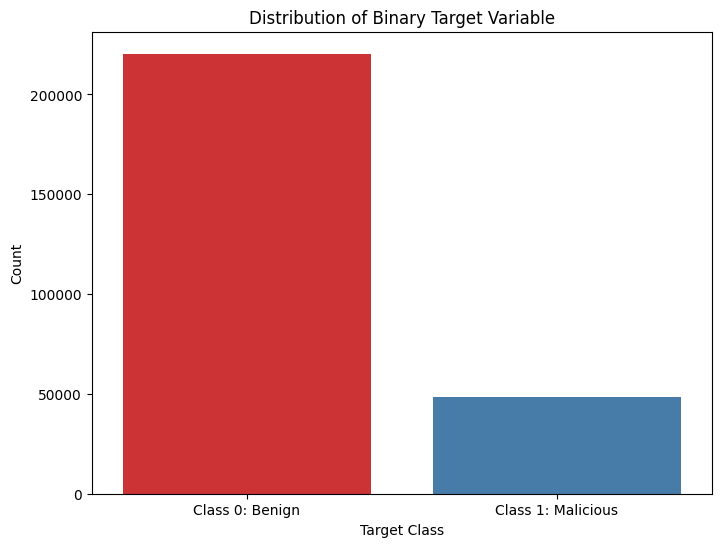

Class 0 ratio: 81.92%
Class 1 ratio: 18.08%


In [ ]:
# 1.2.4 - Visualize dataset imbalance

""" As evident from the output of cell 1.2.2, the dataset exhibits a significant class imbalance."""

# Plotting the distribution of the binary target variable y
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='Set1')
plt.title('Distribution of Binary Target Variable')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Class 0: Benign', 'Class 1: Malicious'])
plt.show()

# Calculate the count and ratio of each class
class_counts = y.value_counts()
class_ratios = class_counts / len(y)

# Print the ratio of each class
print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# Instantiate the Gradient Boosting Regressor
regressor = RandomForestClassifier()

# Train the regressor
regressor.fit(X, y)

# Extract feature importances
feature_importances = regressor.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                    Feature  Importance
54     Avg Bwd Segment Size    0.070190
41        Packet Length Std    0.057397
42   Packet Length Variance    0.056541
39        Max Packet Length    0.055766
52      Average Packet Size    0.050118
..                      ...         ...
61        Bwd Avg Bulk Rate    0.000000
60     Bwd Avg Packets/Bulk    0.000000
59       Bwd Avg Bytes/Bulk    0.000000
58        Fwd Avg Bulk Rate    0.000000
33            Bwd URG Flags    0.000000

[78 rows x 2 columns]


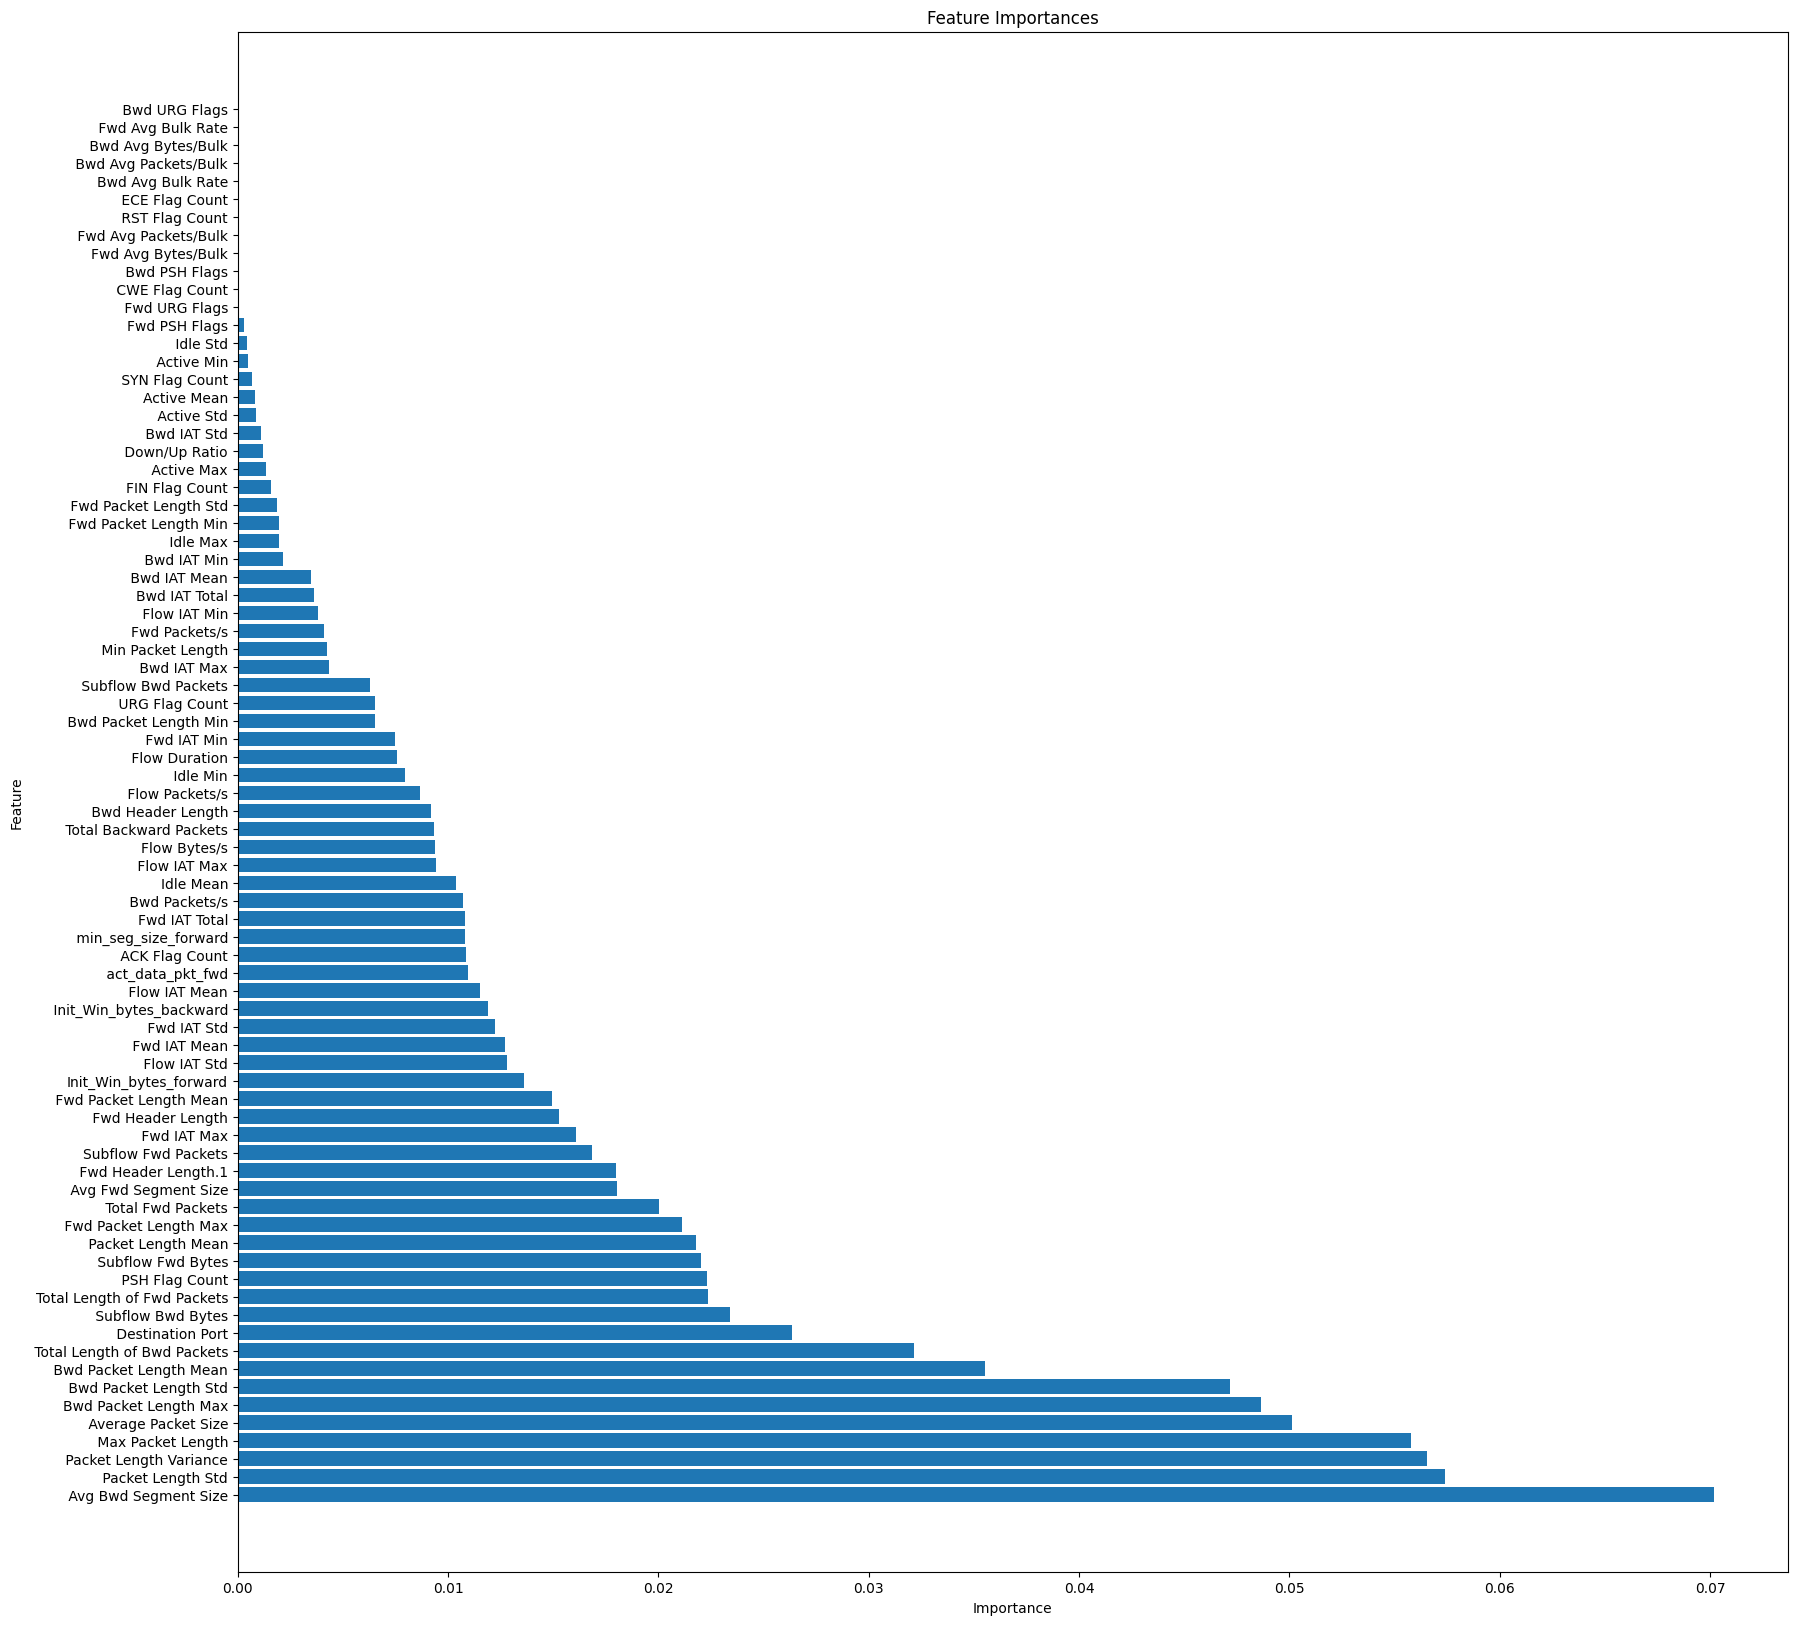

In [ ]:
# Plot the feature importances
plt.figure(figsize=(20, 20))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
# Set a threshold for feature importance (e.g., keep features with importance >= 0.05)
threshold = 0.02

# Filter the DataFrame to keep only features with importance >= threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Drop the less important features from the original DataFrame df
df = df_data[selected_features]
df['Label'] = df_data[' Label']
print(df.shape)
df.head()

(269037, 18)


<ipython-input-82-bbdae571b6c6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df_data[' Label']


,Avg Bwd Segment Size,Packet Length Std,Packet Length Variance,Max Packet Length,Average Packet Size,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Total Length of Bwd Packets,Destination Port,Subflow Bwd Bytes,Total Length of Fwd Packets,PSH Flag Count,Subflow Fwd Bytes,Packet Length Mean,Fwd Packet Length Max,Total Fwd Packets,Label
0,0.000000,0.000000,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,50545,0,0,0,0,0.000000,0,1,BENIGN
1,190.000000,85.444719,7.300800e+03,190,120.500000,190,0.000000,190.000000,380,53,380,68,0,68,96.400000,34,2,BENIGN
2,1656.428571,1538.694445,2.367581e+06,5792,744.500000,5792,2118.227235,1656.428571,11595,80,11595,317,0,317,700.705882,317,9,DoS Hulk
3,86.000000,24.885452,6.192857e+02,86,57.833333,86,0.000000,86.000000,172,53,172,140,0,140,49.571429,35,4,BENIGN
4,83.000000,21.361180,4.563000e+02,83,74.500000,83,0.000000,83.000000,166,53,166,88,0,88,59.600000,44,2,BENIGN


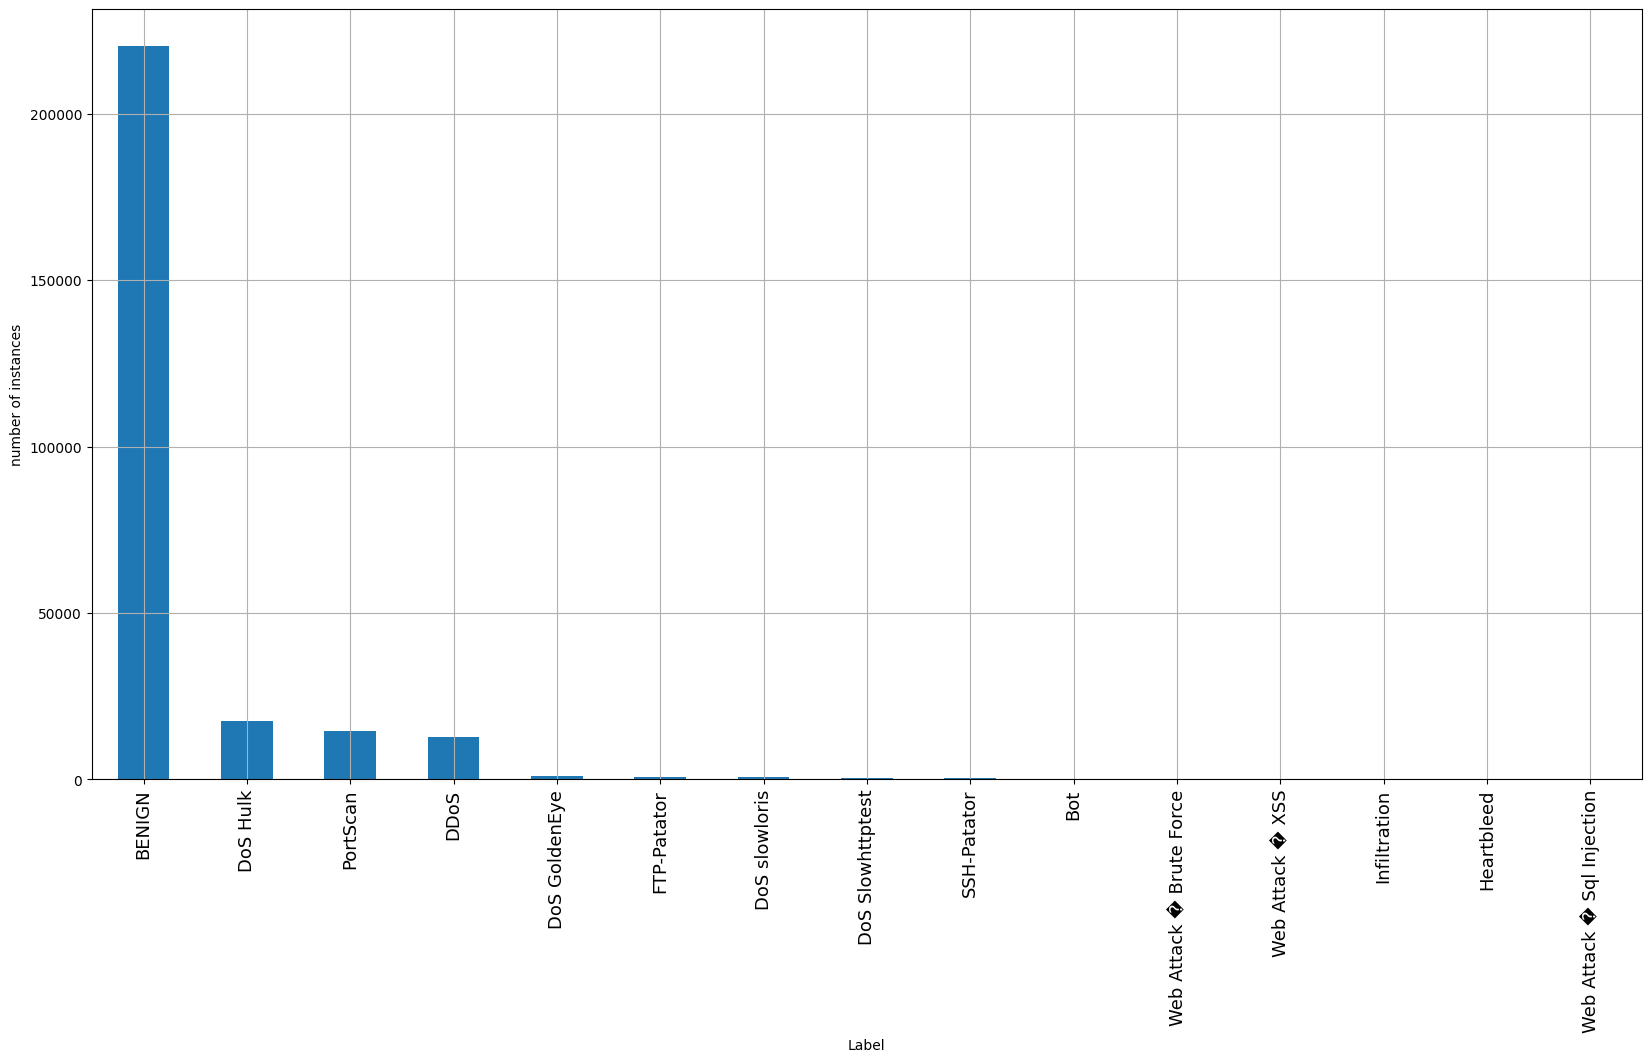

In [ ]:
pd.value_counts(df['Label']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [ ]:
normal_instances = df[df['Label']=='BENIGN'].shape[0]
anomalous_instances = df[df['Label']!='BENIGN'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

220396
48641
percentage of anomalies = 22.069819778943355


In [ ]:
df.head()

,Avg Bwd Segment Size,Packet Length Std,Packet Length Variance,Max Packet Length,Average Packet Size,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Total Length of Bwd Packets,Destination Port,Subflow Bwd Bytes,Total Length of Fwd Packets,PSH Flag Count,Subflow Fwd Bytes,Packet Length Mean,Fwd Packet Length Max,Total Fwd Packets,Label
0,0.000000,0.000000,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,50545,0,0,0,0,0.000000,0,1,BENIGN
1,190.000000,85.444719,7.300800e+03,190,120.500000,190,0.000000,190.000000,380,53,380,68,0,68,96.400000,34,2,BENIGN
2,1656.428571,1538.694445,2.367581e+06,5792,744.500000,5792,2118.227235,1656.428571,11595,80,11595,317,0,317,700.705882,317,9,DoS Hulk
3,86.000000,24.885452,6.192857e+02,86,57.833333,86,0.000000,86.000000,172,53,172,140,0,140,49.571429,35,4,BENIGN
4,83.000000,21.361180,4.563000e+02,83,74.500000,83,0.000000,83.000000,166,53,166,88,0,88,59.600000,44,2,BENIGN


In [ ]:
obj_type = type(df)
print(obj_type)

<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_http_normal = df[df['Label']=='BENIGN']
df_http_normal.drop(columns=['Label'], inplace=True)
df_http_normal.describe()

<ipython-input-87-24d37b209ab5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(columns=['Label'], inplace=True)


,Avg Bwd Segment Size,Packet Length Std,Packet Length Variance,Max Packet Length,Average Packet Size,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Total Length of Bwd Packets,Destination Port,Subflow Bwd Bytes,Total Length of Fwd Packets,PSH Flag Count,Subflow Fwd Bytes,Packet Length Mean,Fwd Packet Length Max,Total Fwd Packets
count,220396.000000,220396.000000,2.203960e+05,220396.000000,220396.000000,220396.000000,220396.000000,220396.000000,2.203960e+05,220396.000000,2.203960e+05,2.203960e+05,220396.000000,2.203960e+05,220396.000000,220396.000000,220396.000000
mean,165.490967,152.652714,1.195214e+05,509.379848,127.452857,408.409685,127.221225,165.490967,1.650723e+04,9693.245631,1.650569e+04,6.467025e+02,0.262718,6.467025e+02,112.406121,237.694577,9.999905
std,287.545155,310.195993,5.796284e+05,1086.881214,200.111461,822.844324,279.105743,287.545155,2.176384e+06,19998.444149,2.175993e+06,5.609646e+03,0.440112,5.609646e+03,190.212514,801.578403,741.338046
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,6.000000,2.190890,4.800000e+00,6.000000,9.000000,6.000000,0.000000,6.000000,6.000000e+00,53.000000,6.000000e+00,1.200000e+01,0.000000,1.200000e+01,6.000000,6.000000,2.000000
50%,79.333333,28.867513,8.333333e+02,94.000000,75.750000,88.000000,0.000000,79.333333,1.360000e+02,80.000000,1.360000e+02,6.800000e+01,0.000000,6.800000e+01,59.857143,41.000000,2.000000
75%,157.000000,101.079831,1.021714e+04,231.000000,127.500000,188.000000,0.000000,157.000000,3.440000e+02,443.000000,3.440000e+02,1.720000e+02,1.000000,1.720000e+02,98.857143,72.000000,4.000000
max,3706.200000,4414.547151,1.948823e+07,24820.000000,3893.333333,19530.000000,2544.494408,3706.200000,6.070000e+08,65534.000000,6.066860e+08,1.231684e+06,1.000000,1.231684e+06,3337.142857,24820.000000,206687.000000


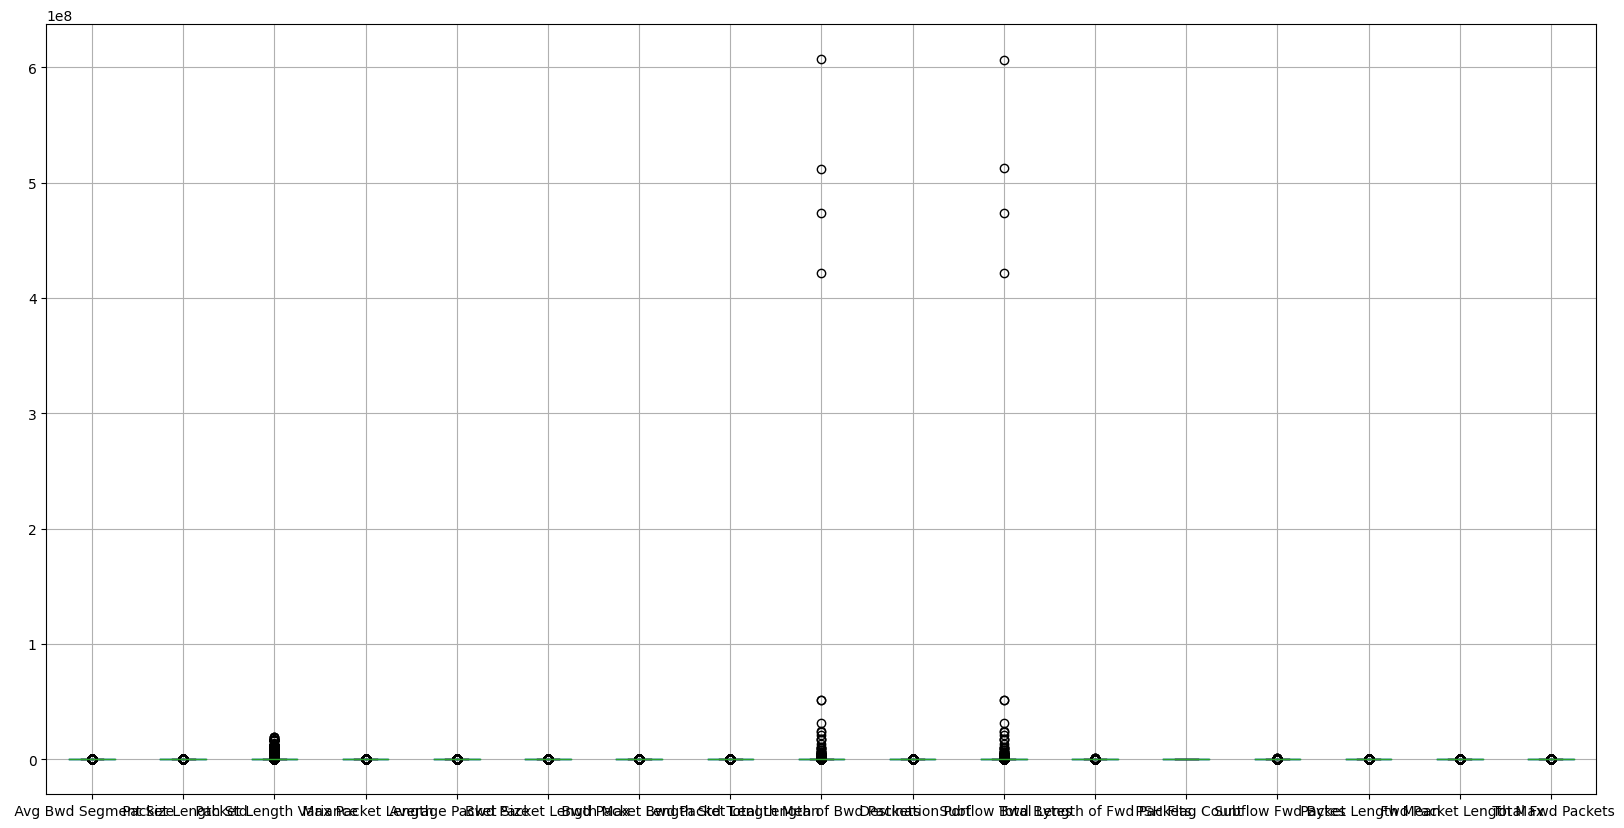

In [ ]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [ ]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [ ]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [ ]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [ ]:
df_pca.head()

,PCA_0,PCA_1,PCA_2
0,-1.744549,0.341801,-0.780830
1,-0.614188,0.011404,0.221411
2,-1.145396,0.144543,0.079954
3,-1.113245,0.133356,0.060769
4,-1.066456,0.122052,0.047531


In [ ]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [ ]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 22039/22039 [00:01<00:00, 21638.56it/s]


In [ ]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [ ]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 3), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(3, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                58760     
                                                                 
 decoder (Sequential)        (None, 10, 3)             56363     
                                                                 
Total params: 115123 (449.70 KB)
Trainable params: 115123 (449.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            26880     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 58760 (229.53 KB)
Trainable params: 58760 (229.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=10, callbacks=[check_point])

Epoch 1/10
275/276 [============================>.] - ETA: 0s - loss: 1.5777
Epoch 1: val_loss improved from inf to 1.30136, saving model to autoencoder.h5
276/276 [==============================] - 23s 81ms/step - loss: 1.5763 - val_loss: 1.3014
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/276 [============================>.] - ETA: 0s - loss: 1.0985
Epoch 2: val_loss improved from 1.30136 to 0.98217, saving model to autoencoder.h5
276/276 [==============================] - 15s 53ms/step - loss: 1.0978 - val_loss: 0.9822
Epoch 3/10
275/276 [============================>.] - ETA: 0s - loss: 0.9607
Epoch 3: val_loss improved from 0.98217 to 0.93958, saving model to autoencoder.h5
276/276 [==============================] - 20s 72ms/step - loss: 0.9598 - val_loss: 0.9396
Epoch 4/10
276/276 [==============================] - ETA: 0s - loss: 0.8765
Epoch 4: val_loss improved from 0.93958 to 0.92642, saving model to autoencoder.h5
276/276 [==============================] - 17s 62ms/step - loss: 0.8765 - val_loss: 0.9264
Epoch 5/10
275/276 [============================>.] - ETA: 0s - loss: 0.8625
Epoch 5: val_loss did not improve from 0.92642
276/276 [==============================] - 16s 58ms/step - loss: 0.8616 - val_loss: 1.1036
Epoch 6/10
275/276 [=======================

In [ ]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [ ]:
test_df_http =df.sample(frac=0.5, random_state=42)
test_df_http.head()

,Avg Bwd Segment Size,Packet Length Std,Packet Length Variance,Max Packet Length,Average Packet Size,Bwd Packet Length Max,Bwd Packet Length Std,Bwd Packet Length Mean,Total Length of Bwd Packets,Destination Port,Subflow Bwd Bytes,Total Length of Fwd Packets,PSH Flag Count,Subflow Fwd Bytes,Packet Length Mean,Fwd Packet Length Max,Total Fwd Packets,Label
7542,2898.75,2470.020432,6101000.936,8699,995.00,8699,4100.748336,2898.75,11595,80,11595,345,0,345,918.461538,345,8,DoS Hulk
217543,89.00,31.220186,974.700,89,68.50,89,0.000000,89.00,178,53,178,64,0,64,54.800000,32,2,BENIGN
123800,122.00,44.370035,1968.700,130,92.25,130,11.313709,122.00,244,53,244,84,0,84,73.800000,43,2,BENIGN
232724,0.00,3.000000,9.000,6,6.00,0,0.000000,0.00,0,80,0,12,0,12,4.500000,6,2,DoS Hulk
218707,0.00,0.000000,0.000,0,0.00,0,0.000000,0.00,0,41406,0,0,0,0,0.000000,0,2,BENIGN


In [ ]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='BENIGN' else 1 for i in test_df_http['Label']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [ ]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http.drop(columns = ['Label'])), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2
0,1.455058e+06,11641.817601,-2.587471e+06
1,4.339523e+02,182.852542,-3.613184e+02
2,7.522471e+02,244.595376,-7.535940e+02
3,9.024715e+00,13.255245,-3.550061e+01
4,-2.294243e+03,1948.785946,-1.245858e+04


In [ ]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 13451/13451 [00:01<00:00, 12959.65it/s]


In [ ]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

421/421 [==============================] - 5s 10ms/step


In [ ]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [ ]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [ ]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

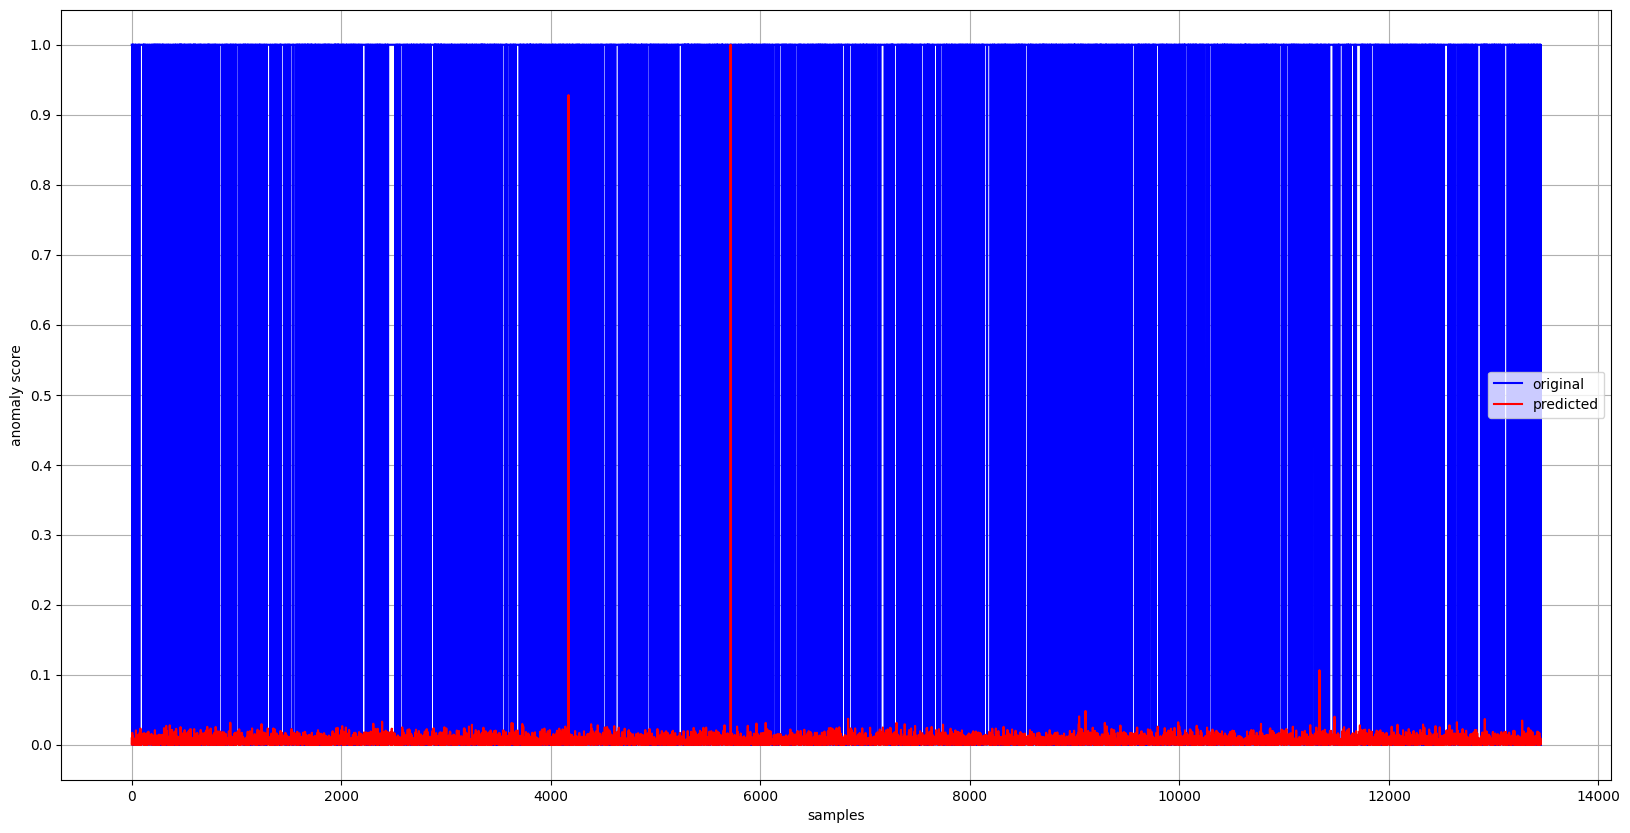

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [ ]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.8103026445035715


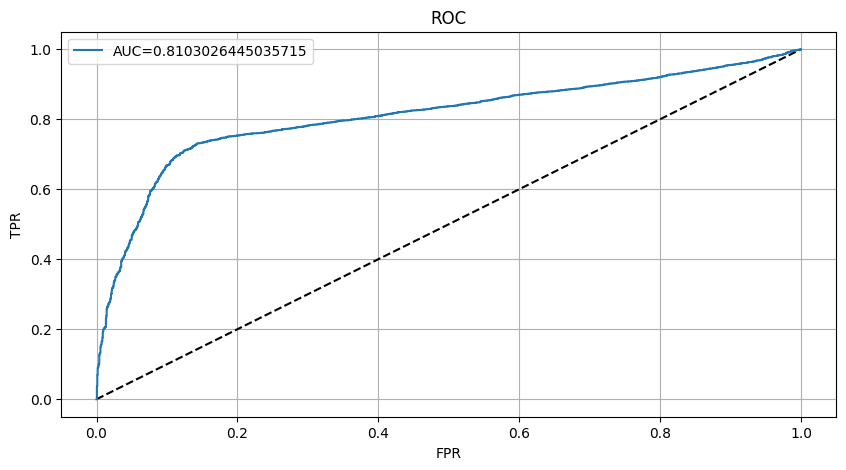

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [ ]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

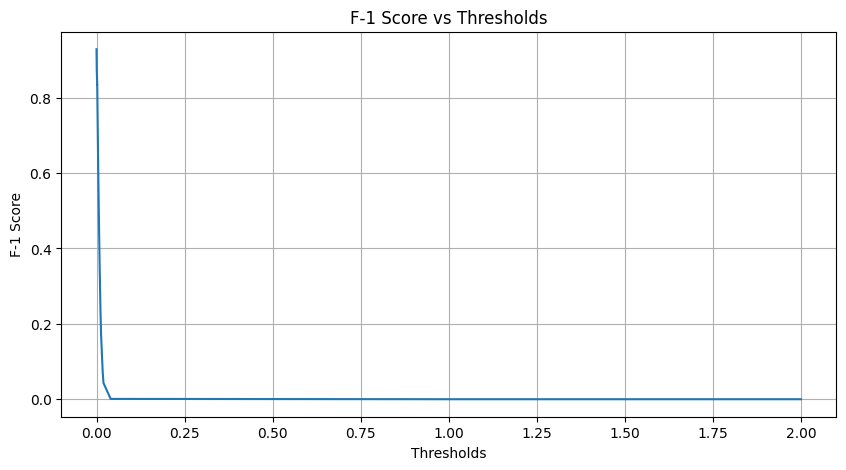

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [ ]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.0


In [ ]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [ ]:
confusion_matrix(test_labels, anomaly_indicator)

array([[    0,  1800],
       [    1, 11650]])

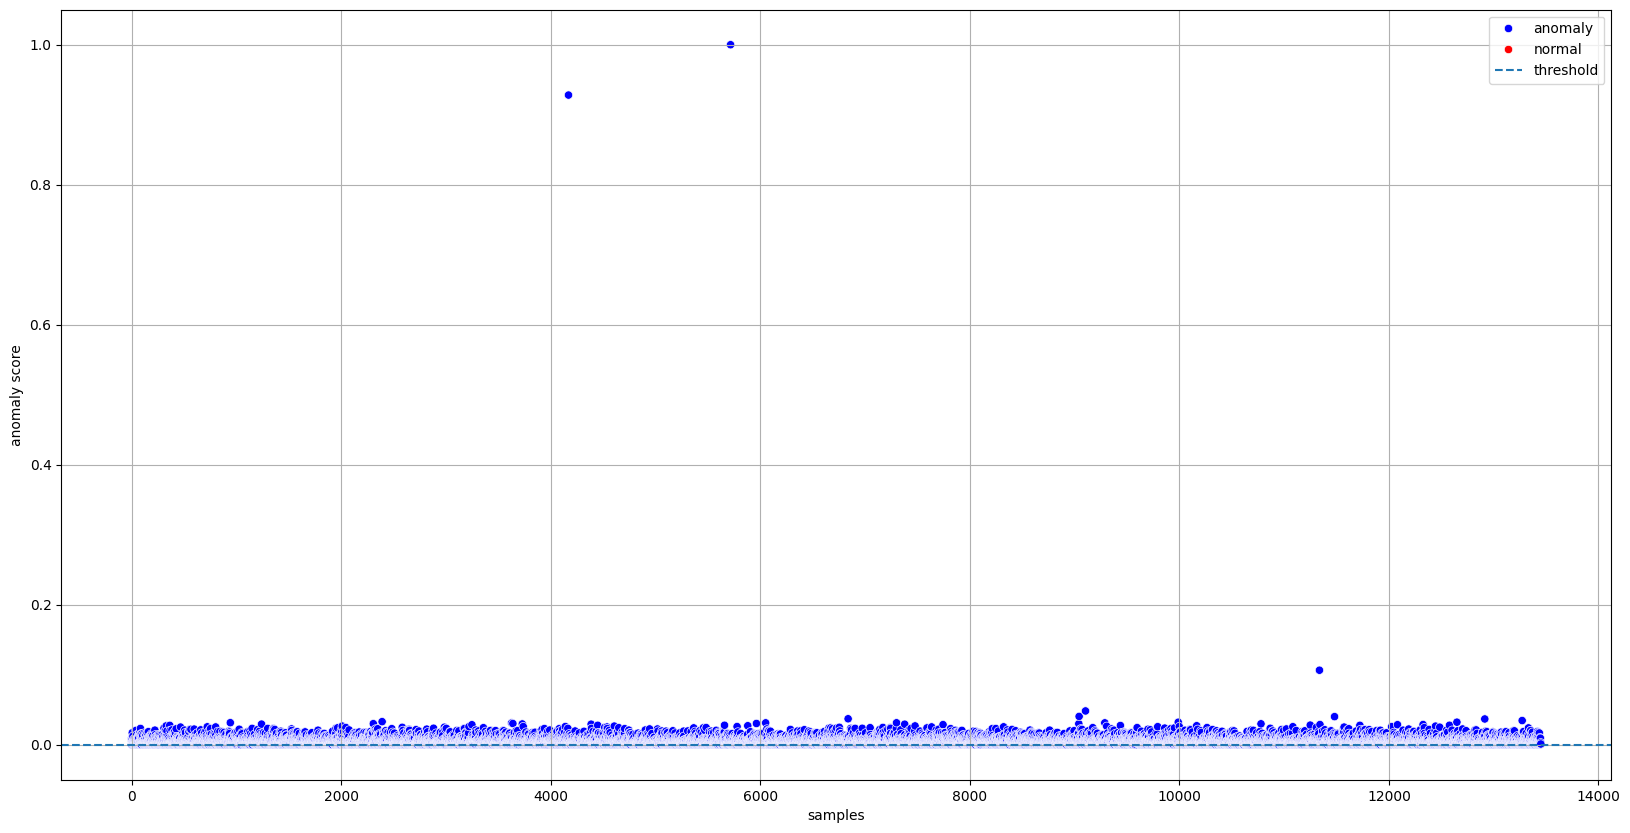

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [ ]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.8661710037174721
 recall = 0.9999141704574714
 f1_score = 0.9282498705230867
 accuracy_score = 0.8661066091740391
